# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = './traffic-signs-data/train.p'
testing_file = './traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

FEATURES = 'features'
LABELS = 'labels'
SIZES = 'sizes'
COORDS = 'coords'

X_train_raw, y_train_raw, Sizes_train, Coords_train = train[FEATURES], train[LABELS], train[SIZES], train[COORDS]
X_test, y_test, Sizes_test, Coords_test = test[FEATURES], test[LABELS], train[SIZES], train[COORDS]  

print(X_train_raw.shape,y_train_raw.shape,X_test.shape,y_test.shape)
print(Sizes_train.shape,Sizes_test.shape,Coords_train.shape,Coords_test.shape)




(39209, 32, 32, 3) (39209,) (12630, 32, 32, 3) (12630,)
(39209, 2) (39209, 2) (39209, 4) (39209, 4)


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [2]:
### Replace each question mark with the appropriate value.

# TODO: Number of training examples
n_train_raw = X_train_raw.shape[0]

# TODO: Number of testing examples.
n_test = X_test.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = X_test.shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = 43

print("Number of training examples =", n_train_raw)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)



Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (12630, 32, 32, 3)
Number of classes = 43


In [3]:
#jitter generating function implemented  by Vivek Yadav
import cv2
def transform_image(img,ang_range,shear_range,trans_range):
    '''
    This function transforms images to generate new images.
    The function takes in following arguments,
    1- Image
    2- ang_range: Range of angles for rotation
    3- shear_range: Range of values to apply affine transform to
    4- trans_range: Range of values to apply translations over. 
    
    A Random uniform distribution is used to generate different parameters for transformation
    
    '''
    # Rotationsave_file
    #print(img.shape)
    
    ang_rot = np.random.uniform(ang_range)-ang_range/2
    rows,cols,ch = img.shape    
    Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),ang_rot,1)

    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])

    # Shear
    pts1 = np.float32([[5,5],[20,5],[5,20]])

    pt1 = 5+shear_range*np.random.uniform()-shear_range/2
    pt2 = 20+shear_range*np.random.uniform()-shear_range/2

    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])

    shear_M = cv2.getAffineTransform(pts1,pts2)
        
    img = cv2.warpAffine(img,Rot_M,(cols,rows))
    img = cv2.warpAffine(img,Trans_M,(cols,rows))
    img = cv2.warpAffine(img,shear_M,(cols,rows))
    #print(img.shape)
    return img

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

My tried actions;first,get a view of random image ,then,view different label image of the same class id of the traffic sign.

the corresponding label/class id of the traffic sign is  31


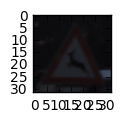

In [4]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import random
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

#labelID=33
#while 1:
index = random.randint(0, len(X_train_raw))
#    if y_train[index]==labelID:break        

image = X_train_raw[index].squeeze()


plt.figure(figsize=(1,1))
plt.imshow(image)
#plt.imshow(image, cmap="gray")
print("the corresponding label/class id of the traffic sign is ",y_train_raw[index])



Sample test images: 100%|██████████████████████████████████████████████████████████| 43/43 [00:17<00:00,  1.57labels/s]


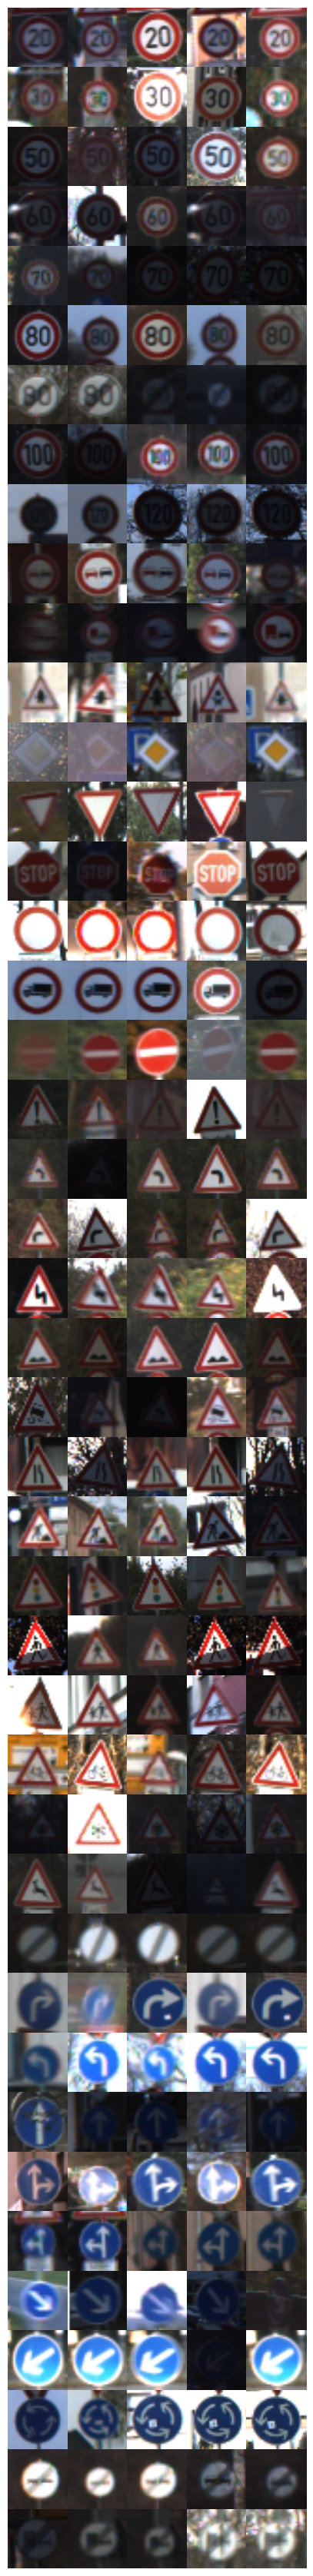

In [5]:
import matplotlib.gridspec as gridspec
from tqdm import *

sample_size = 5 #five images per class label
n_labels = 43
count = 0 #book keeping for plots
fig = plt.figure(figsize=(sample_size, n_labels))
grid = gridspec.GridSpec(n_labels, sample_size, wspace=0.0, hspace=0.0)
labelset_pbar = tqdm(range(n_labels), desc='Sample test images', unit='labels')
for i in labelset_pbar:
    ind = y_test == i
    subset_x = X_test[ind,] #get all images that belong to class i
    for x in range(sample_size):
        img = random.choice(subset_x) #randomly pick on image from class i
        ax = plt.Subplot(fig, grid[count])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(img, cmap='gray')
        fig.add_subplot(ax)
        count +=1

    # hide the borders
    if i == (n_labels-1):
        all_axes = fig.get_axes()
        for ax in all_axes:
            for sp in ax.spines.values():
                sp.set_visible(False)
plt.show()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [6]:
# see how many input data for each class id of traffic sign
import numpy as np
import random 
num_classID=np.zeros(n_classes)

for i in range(len(y_train_raw)):
    num_classID[y_train_raw[i]]+=1
n_label_max=np.max(num_classID)
print(num_classID)
print(n_label_max)

[  210.  2220.  2250.  1410.  1980.  1860.   420.  1440.  1410.  1470.
  2010.  1320.  2100.  2160.   780.   630.   420.  1110.  1200.   210.
   360.   330.   390.   510.   270.  1500.   600.   240.   540.   270.
   450.   780.   240.   689.   420.  1200.   390.   210.  2070.   300.
   360.   240.   240.]
2250.0


In [7]:
#split training dato into training and validation set
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

ration_validation=0.33
X_train_unjittered, X_validation_unjittered, y_train_unjittered, y_validation_unjittered = train_test_split(train["features"], train['labels'], test_size=ration_validation, random_state=0)
X_train_unjittered,y_train_unjittered = shuffle(X_train_unjittered, y_train_unjittered)
X_validation_unjittered,y_validation_unjittered = shuffle(X_validation_unjittered, y_validation_unjittered)

n_validation=len(X_validation_unjittered)
n_train=len(X_train_unjittered)

#n_validation=int(ration_validation*n_train_raw)
#n_train=n_train_raw-n_validation

#X_train_unjittered= X_train_raw[:n_train]
#y_train_unjittered= y_train_raw[:n_train]
#X_validation_unjittered = X_train_raw[n_train:]
#y_validation_unjittered = y_train_raw[n_train:]
print(n_train,n_validation)
print(X_train_unjittered.shape,y_train_unjittered.shape,X_validation_unjittered.shape,y_validation_unjittered.shape)

num_train_classID=np.zeros(n_classes)
num_validation_classID=np.zeros(n_classes)

for i in range(n_train):
    num_train_classID[y_train_unjittered[i]]+=1
n_train_label_max=np.max(num_train_classID)
print(num_train_classID)
print("the maximum number of a label in training set is ",n_train_label_max)

for i in range(n_validation):
    num_validation_classID[y_validation_unjittered[i]]+=1
n_validation_label_max=np.max(num_validation_classID)
print(num_validation_classID)
print("the maximum number of a label in validation set is ",n_validation_label_max)




26270 12939
(26270, 32, 32, 3) (26270,) (12939, 32, 32, 3) (12939,)
[  139.  1487.  1519.   944.  1318.  1244.   273.   939.   966.  1006.
  1345.   867.  1440.  1425.   492.   419.   277.   746.   845.   152.
   239.   229.   267.   335.   168.   973.   408.   156.   337.   173.
   296.   516.   173.   489.   297.   838.   269.   133.  1357.   199.
   237.   166.   172.]
the maximum number of a label in training set is  1519.0
[  71.  733.  731.  466.  662.  616.  147.  501.  444.  464.  665.  453.
  660.  735.  288.  211.  143.  364.  355.   58.  121.  101.  123.  175.
  102.  527.  192.   84.  203.   97.  154.  264.   67.  200.  123.  362.
  121.   77.  713.  101.  123.   74.   68.]
the maximum number of a label in validation set is  735.0


In [8]:
# generate jitter data ,making data balanceed
X_train=[]
y_train=[]
X_validation=[]
y_validation=[]
n_times=1
print("n_train is" ,n_train," n_validation is",n_validation)
for m in range(n_times):
    for i in range(n_train):
         for j in range(n_classes):
            if y_train_unjittered[i]==j:
                for k in range(int(round(n_train_label_max/num_train_classID[j]))):
                    img = transform_image(X_train_unjittered[i],10,5,5)
                    X_train.append(img)
                    y_train.append(y_train_unjittered[i])
print("the jitter trainning data size is",len(X_train))
for i in range(n_train):
    X_train.append(X_train_unjittered[i])
    y_train.append(y_train_unjittered[i])
    
X_train=np.array(X_train)
y_train=np.array(y_train)
n_train=len(X_train)
print("the shape of final X_train ,y_train is",X_train.shape,y_train.shape)

      
for m in range(n_times):
    for i in range(n_validation):
        for j in range(n_classes):
            if y_validation_unjittered[i]==j:
                for k in range(int(round(n_validation_label_max/num_validation_classID[j]))):
                    img = transform_image(X_validation_unjittered[i],10,5,5)
                    X_validation.append(img)
                    y_validation.append(y_validation_unjittered[i])
                    
print("the jitter validation data size is",len(X_validation))
for i in range(n_validation):                    
    X_validation.append(X_validation_unjittered[i])
    y_validation.append(y_validation_unjittered[i])

X_validation=np.array(X_validation)
y_validation=np.array(y_validation)
n_validation=len(X_validation)


print("the shape of final X_validation ,y_validation is",X_validation.shape,y_validation.shape)

X_train,y_train = shuffle(X_train, y_train)
X_validation,y_validation = shuffle(X_validation, y_validation)

"""
n_validation=n_train_raw

X_validation=X_train_raw
y_validation=y_train_raw

X_train=[]
y_train=[]
#for k in range(4):
for i in range(len(y_train_raw)):
    for j in range(n_classes):
        if y_train_raw[i]==j:
            for k in range(int(round(n_label_max/num_classID[j]))):
                img = transform_image(image,10,5,2)
                X_train.append(img)
                y_train.append(y_train_raw[i])
X_train=np.array(X_train)
y_train=np.array(y_train)
n_train=len(X_train)

print("the shape of X_train y_train is",X_train.shape,y_train.shape)

        
"""


"""
image =imread()
plt.imshow(image);
plt.axis('off');
plt.show()
gs1 = gridspec.GridSpec(10, 10)
gs1.update(wspace=0.01, hspace=0.02) # set the spacing between axes. 
plt.figure(figsize=(12,12))
for i in range(100):
    ax1 = plt.subplot(gs1[i])
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_aspect('equal')
    img = transform_image(image,20,10,5)

    plt.subplot(10,10,i+1)
    plt.imshow(img)
    plt.axis('off')

plt.show()
"""

n_train is 26270  n_validation is 12939
the jitter trainning data size is 67537
the shape of final X_train ,y_train is (93807, 32, 32, 3) (93807,)
the jitter validation data size is 31733
the shape of final X_validation ,y_validation is (44672, 32, 32, 3) (44672,)


"\nimage =imread()\nplt.imshow(image);\nplt.axis('off');\nplt.show()\ngs1 = gridspec.GridSpec(10, 10)\ngs1.update(wspace=0.01, hspace=0.02) # set the spacing between axes. \nplt.figure(figsize=(12,12))\nfor i in range(100):\n    ax1 = plt.subplot(gs1[i])\n    ax1.set_xticklabels([])\n    ax1.set_yticklabels([])\n    ax1.set_aspect('equal')\n    img = transform_image(image,20,10,5)\n\n    plt.subplot(10,10,i+1)\n    plt.imshow(img)\n    plt.axis('off')\n\nplt.show()\n"

In [9]:
#preprocessing the input data  :RGB to YUV  Gray Y = R*0.299 + G*0.587 + B*0.114
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])
    
#X_train_gray=np.array([n_train,32,32,1])
#X_test_gray=np.array([n_test,32,32,1])

X_train_gray=np.array(rgb2gray(X_train),dtype=np.float32).reshape((n_train,32,32,1))
X_test_gray=np.array(rgb2gray(X_test),dtype=np.float32).reshape((n_test,32,32,1))
X_validation_gray=np.array(rgb2gray(X_validation),dtype=np.float32).reshape((n_validation,32,32,1))

print("the shape of X_train_gray is ",X_train_gray.shape)
print("the shape of X_validation_gray is ",X_validation_gray.shape)
print("the shape of X_test_gray is ",X_test_gray.shape)


#print("y_test",y_test)



the shape of X_train_gray is  (93807, 32, 32, 1)
the shape of X_validation_gray is  (44672, 32, 32, 1)
the shape of X_test_gray is  (12630, 32, 32, 1)


In [10]:
#data normalizing
import tensorflow as tf

def image_normalizing(data):
    d=np.array(data)
    shape=d.shape
    d=d.reshape(d.size)
    for i in range(d.size):
        d[i]=np.float32((d[i]-128)/128)
    return d.reshape(shape)

X_train_gray_normal=image_normalizing(X_train_gray)
X_test_gray_normal=image_normalizing(X_test_gray)
X_validation_gray_normal=image_normalizing(X_validation_gray)

print("the shape of X_train_gray_normal is ",X_train_gray_normal.shape)
print("the shape of X_validation_gray_normal is ",X_validation_gray_normal.shape)
print("the shape of X_test_gray_normal is ",X_test_gray_normal.shape)

        
#print("X_train_gray_normal",X_train_gray_normal)  
#print("one_hot_y_test",one_hot_y_test)


the shape of X_train_gray_normal is  (93807, 32, 32, 1)
the shape of X_validation_gray_normal is  (44672, 32, 32, 1)
the shape of X_test_gray_normal is  (12630, 32, 32, 1)


In [11]:
# using the leNet structure fist


from tensorflow.contrib.layers import flatten
#shuffling the data pair
X_train_gray_normal,y_train = shuffle(X_train_gray_normal, y_train)

EPOCHS = 150
BATCH_SIZE = 128
#dropout_rate = 0.750
keep_prob = tf.placeholder(tf.float32)

def LeNet(x):    
    # Hyperparameters
    mu = 0
    sigma = 0.1
    
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)

    # SOLUTION: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)

    # SOLUTION: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)

    # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)

    # SOLUTION: Layer 5: Fully Connected. Input = 84. Output =  n_classes,in this case equals 43
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84,  n_classes), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros( n_classes))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits


def LeNetModify1(x):    
    # Hyperparameters
    mu = 0
    sigma = 0.1
    
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x16.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 16), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(16))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)

    # SOLUTION: Pooling. Input = 28x28x16. Output = 14x14x16.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Layer 2: Convolutional. Output = 10x10x32.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 16, 32), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(32))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)

    # SOLUTION: Pooling. Input = 10x10x32. Output = 5x5x32.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)
    
    # SOLUTION: Dropput
    conv2 = tf.nn.dropout(conv2, keep_prob)

    # SOLUTION: Flatten. Input = 5x5x32. Output = 800.
    fc0   = flatten(conv2)
    
    # SOLUTION: Layer 3: Fully Connected. Input = 800. Output = 256.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(800, 256), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(256))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)

    # SOLUTION: Layer 4: Fully Connected. Input = 256. Output = 128.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(256, 128), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(128))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)

    # SOLUTION: Layer 5: Fully Connected. Input = 128. Output =  n_classes,in this case equals 43
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(128,  n_classes), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros( n_classes))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits




In [12]:
# training pipeline

x = tf.placeholder(tf.float32, (None, 32, 32,1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)

rate = 0.001
#logits=LeNet(x)
logits = LeNetModify1(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)



In [13]:
#evaluating function

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy,loss = sess.run([accuracy_operation,loss_operation], feed_dict={x: batch_x, y: batch_y , keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples,loss

In [14]:
# model training
save_file='./model3.ckpt'
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    num_examples = len(X_train_gray_normal)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train_gray_normal, y_train = shuffle(X_train_gray_normal, y_train)
        #print("X_train_gray_normal.shape",X_train_gray_normal.shape)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_gray_normal[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
            
        validation_accuracy,validation_loss = evaluate(X_validation_gray_normal, y_validation)
        print("EPOCH {} ...".format(i+1))
        #print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print("Validation loss = {:.3f}     ".format(validation_loss),"Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        #if validation_accuracy>0.99:
            #break
    
    # try test dat accuray
    #test_accuracy,test_loss = evaluate(X_test_gray_normal, y_test)
    #print("Test Accuracy = {:.3f}".format(test_accuracy))
    #print("test dada loss = {:.3f}     ".format(test_loss),"Test Accuracy = {:.3f}".format(test_accuracy))
    
    saver.save(sess,save_file)
    print("Model saved")

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Training...

EPOCH 1 ...
Validation loss = 0.614      Validation Accuracy = 0.830

Model saved


In [15]:
# evalute the model
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# Remove the previous weights and bias
#tf.reset_default_graph()

save_file='./model3.ckpt'
#saver = tf.train.Saver()
with tf.Session() as sess:
    saver = tf.train.import_meta_graph(save_file+'.meta')
    saver.restore(sess, tf.train.latest_checkpoint('./'))
    #all_vars = tf.trainable_variables()
    #for v in all_vars:
        #print(v.name)
    #sess.run(tf.initialize_all_variables())
    #ckpt = tf.train.get_checkpoint_state("./")
    #if ckpt and ckpt.model_checkpoint_path:
        #print("Continue training from the model {}".format(ckpt.model_checkpoint_path))
        #print(saver)
        #print(saver.restore(sess, ckpt.model_checkpoint_path))
    #ckpt = tf.train.import_meta_graph('model.ckpt.meta')
    #ckpt.restore(sess, './model.ckpt')
    
    print(save_file)
    
   
    #saver.restore(sess,save_file)
    #loader.restore(sess, tf.train.latest_checkpoint('./'))

    test_accuracy,test_loss = evaluate(X_test_gray_normal, y_test)
    #print(test_accuracy.eval(session=sess))
    #print("Test Accuracy = {:.3f}".format(test_accuracy))
    print("test dada loss = {:.3f}     ".format(test_loss),"Test Accuracy = {:.3f}".format(test_accuracy))
    

"""
    file_path="./download signs/"
    file_list=os.listdir(file_path)
    print(file_list)
    web_images=[]
    web_labels=[1,13,14,15,17,18,21,26,27,31,35]
    for i in range(len(file_list)):
        image = mpimg.imread(file_path+file_list[i])
        image=cv2.resize(image, (32, 32))
        web_images.append(image)
    web_images=np.array(web_images)
    web_images_gray=np.array(rgb2gray(web_images),dtype=np.float32).reshape((len(web_images),32,32,1))
    web_images_gray_normal=image_normalizing(web_images_gray)

    web_images_test_accuracy,web_images_test_loss = evaluate(web_images_gray_normal, web_labels)
    print("web images test dada loss = {:.3f}     ".format(web_images_test_loss),"web_images Test Accuracy = {:.3f}".format(test_accuracy))
"""

./model3.ckpt
test dada loss = 0.477      Test Accuracy = 0.876


'\n    file_path="./download signs/"\n    file_list=os.listdir(file_path)\n    print(file_list)\n    web_images=[]\n    web_labels=[1,13,14,15,17,18,21,26,27,31,35]\n    for i in range(len(file_list)):\n        image = mpimg.imread(file_path+file_list[i])\n        image=cv2.resize(image, (32, 32))\n        web_images.append(image)\n    web_images=np.array(web_images)\n    web_images_gray=np.array(rgb2gray(web_images),dtype=np.float32).reshape((len(web_images),32,32,1))\n    web_images_gray_normal=image_normalizing(web_images_gray)\n\n    web_images_test_accuracy,web_images_test_loss = evaluate(web_images_gray_normal, web_labels)\n    print("web images test dada loss = {:.3f}     ".format(web_images_test_loss),"web_images Test Accuracy = {:.3f}".format(test_accuracy))\n'

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

### Generate data additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.
first ,i split the data into trainding data/validation data with a ratio of 27447/ 11762, with same model, it can reach 94% accurate rate at maximum.
second, i seperately generate the jittered training data and valdation data for previous splitted trainding data and validation data with a ratio of 96741/30260 ,then the accurate rise up 
besides,for both raw data and jittered data ,i convert all the data from rgb to y channel of yuv, and then normalizing them


#split training dato into training and validation set
from sklearn.utils import shuffle

X_train_raw,y_train_raw = shuffle(X_train_raw, y_train_raw)

n_validation=int(0.3*n_train_raw)
n_train=n_train_raw-n_validation

X_train_unjittered= X_train_raw[:n_train]
y_train_unjittered= y_train_raw[:n_train]
X_validation_unjittered = X_train_raw[n_train:]
y_validation_unjittered = y_train_raw[n_train:]

# generate jitter data ,making data balanceed
X_train=[]
y_train=[]
X_validation=[]
y_validation=[]
n_times=1
print("n_train" ,n_train)
for m in range(n_times):
    for i in range(n_train):
         for j in range(n_classes):
            if y_train_unjittered[i]==j:
                for k in range(int(round(n_train_label_max/num_train_classID[j]))):
                    img = transform_image(X_train_unjittered[i],10,5,5)
                    X_train.append(img)
                    y_train.append(y_train_unjittered[i])
print("the jitter trainning data size is",len(X_train))
for i in range(n_train):
    X_train.append(X_train_unjittered[i])
    y_train.append(y_train_unjittered[i])
    
X_train=np.array(X_train)
y_train=np.array(y_train)
n_train=len(X_train)
print("the shape of final X_train ,y_train is",X_train.shape,y_train.shape)

      
for m in range(n_times):
    for i in range(n_validation):
        for j in range(n_classes):
            if y_validation_unjittered[i]==j:
                for k in range(int(round(n_validation_label_max/num_validation_classID[j]))):
                    img = transform_image(X_validation_unjittered[i],10,5,5)
                    X_validation.append(img)
                    y_validation.append(y_validation_unjittered[i])
                    
print("the jitter trainning data size is",len(X_validation))
for i in range(n_validation):                    
    X_validation.append(X_validation_unjittered[i])
    y_validation.append(y_validation_unjittered[i])

X_validation=np.array(X_validation)
y_validation=np.array(y_validation)
n_validation=len(X_validation)


print("the shape of final X_validation ,y_validation is",X_validation.shape,y_validation.shape)

X_train,y_train = shuffle(X_train, y_train)
X_validation,y_validation = shuffle(X_validation, y_validation)

#preprocessing the input data  :RGB to YUV  Gray Y = R*0.299 + G*0.587 + B*0.114
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])
    
#X_train_gray=np.array([n_train,32,32,1])
#X_test_gray=np.array([n_test,32,32,1])

X_train_gray=np.array(rgb2gray(X_train),dtype=np.float32).reshape((n_train,32,32,1))
X_test_gray=np.array(rgb2gray(X_test),dtype=np.float32).reshape((n_test,32,32,1))
X_validation_gray=np.array(rgb2gray(X_validation),dtype=np.float32).reshape((n_validation,32,32,1))

#data normalizing
import tensorflow as tf

def image_normalizing(data):
    d=np.array(data)
    shape=d.shape
    d=d.reshape(d.size)
    for i in range(d.size):
        d[i]=np.float32((d[i]-128)/128)
    return d.reshape(shape)

X_train_gray_normal=image_normalizing(X_train_gray)
X_test_gray_normal=image_normalizing(X_test_gray)
X_validation_gray_normal=image_normalizing(X_validation_gray)

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

### Define your architecture here.
### Feel free to use as many code cells as needed.
i keep the testing data untouched ,just the same as the input test data.
and seperate the original training data into two part ,the training data with jittered traing data, the validation data with jittered validation data,
besides  with jittered data ,i balance the data samples for each traffic sign label avoiding from the tendency model by the unbalanced data imput.
in order to make the model more robust, i refer to thejitter generating function implemented  by Vivek Yadav which can ramdomly rotate,shear,translation transform the input data

with the generated data ,the training data become larger and more random jittered whichi tend to output a more robutst model.


### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

### the model final.
### Feel free to use as many code cells as needed.
first,i use a simple linear regression structure whichi yield not good accurate.
then i choose a lenet model ,it turns better.
and finaly i choose a modified lenet model,whichi shows a satisfied result.

the architeture is below:
first: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x16. with a 16 channels different 5x5x1 filters
followed by a relu activation 
then resampling by a max pooling with a [1,2,2,1]stride which output  14x14x16.
secondly,Layer 2: Convolutional. Output = 10x10x32. with a 32 channels different 5x5x1 filters
follows by another relu activation
and then another max pooling with a [1,2,2,1]stride which output  5x5x32..
thirdly ,the flatten layer with an output of 800 nodes
fouthly,fully Connected layer of linear regression. with Input = 800. Output = 256.
followed by another relu activation
fifthly,Fully Connected layer. Input = 256. Output = 128.
followed by another relu activation
finally,Fully Connected output layer. Input = 128. Output =  43


def LeNetModify1(x):    
    # Hyperparameters
    mu = 0
    sigma = 0.1
    
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x16.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 16), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(16))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)

    # SOLUTION: Pooling. Input = 28x28x16. Output = 14x14x16.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Layer 2: Convolutional. Output = 10x10x32.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 16, 32), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(32))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)

    # SOLUTION: Pooling. Input = 10x10x32. Output = 5x5x32.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Flatten. Input = 5x5x32. Output = 800.
    fc0   = flatten(conv2)
    
    # SOLUTION: Layer 3: Fully Connected. Input = 800. Output = 256.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(800, 256), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(256))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)

    # SOLUTION: Layer 4: Fully Connected. Input = 256. Output = 128.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(256, 128), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(128))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)

    # SOLUTION: Layer 5: Fully Connected. Input = 128. Output =  n_classes,in this case equals 43
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(128,  n_classes), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros( n_classes))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

i use the  tf.train.AdamOptimizer wih the hyperparameters as belows:
    learning rate = 0.001
    batch size=128
    epochs=200
    ration_validation=0.3
    mu=0
    sigma=0.1
    transform_image(image,ang_range=10,shear_range=5,trans_range=5)
    keep_prob=0.5
    
    
    
    


### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

first,,i use a simple linear regression structure whichi yield not good accurate.
then i choose a lenet model because i think that the conv net is effective in processing image inputs.and i got an accuracy about 89%
then i try a wider modified lenet model,whichi shows a satisfied result of 94%
and i come back to add more generating data to see how much it can improve the accuracy,
and i found it takes more computing time,first i set epoches to 30 ,which i can see the model is not converged in the last epoque,
so i set epoches to 100 ,which i can see the model is converged.
and i try to update the batch size to 256 to make it run faster, but it cosumes more memory which my computer cann't afford.
so i finally choose  the batch size 128'
and after web test data testing,i add the dropout to avoid overfitting

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [16]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
file_path="./download signs/"
file_list=os.listdir(file_path)
print(file_list)
web_images=[]
web_labels=[1,13,14,15,17,18,21,26,27,31,35]
for i in range(len(file_list)):
    image = mpimg.imread(file_path+file_list[i])
    image=cv2.resize(image, (32, 32))
    web_images.append(image)
web_images=np.array(web_images)
web_images_gray=np.array(rgb2gray(web_images),dtype=np.float32).reshape((len(web_images),32,32,1))
web_images_gray_normal=image_normalizing(web_images_gray)
#web_labels=np.array(web_labels).astype(int)

# Remove the previous weights and bias
#tf.reset_default_graph()

save_file='./model3.ckpt'
#saver = tf.train.Saver()
with tf.Session() as sess:
    saver = tf.train.import_meta_graph(save_file+'.meta')
    saver.restore(sess, tf.train.latest_checkpoint('./'))
    #sess.run(tf.initialize_all_variables())
    #ckpt = tf.train.get_checkpoint_state("./")
    #if ckpt and ckpt.model_checkpoint_path:
        #print("Continue training from the model {}".format(ckpt.model_checkpoint_path))
        #print(saver)
        #print(saver.restore(sess, ckpt.model_checkpoint_path))
    #ckpt = tf.train.import_meta_graph('model.ckpt.meta')
    #ckpt.restore(sess, './model.ckpt')
    #print(saver.restore(sess,save_file))
    
    #web_images_test_accuracy = evaluate(web_images_gray_normal, web_labels)
    #print("Test Accuracy = {:.3f}".format(test_accuracy))
    web_images_test_accuracy,web_images_test_loss = evaluate(web_images_gray_normal, web_labels)
    print("web images test dada loss = {:.3f}     ".format(web_images_test_loss),"web_images Test Accuracy = {:.3f}".format(test_accuracy))


['1.jpg', '13.jpg', '14.jpg', '15.jpg', '17.jpg', '18.jpg', '21.jpg', '26.jpg', '27.jpg', '31.jpg', '35.jpg']
web images test dada loss = 2.466      web_images Test Accuracy = 0.876


### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

In [26]:
### Run the predictions here.
### Feel free to use as many code cells as needed.
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

"""
def evaluation(logits, labels):
    Evaluate the quality of the logits at predicting the label.

  Args:
    logits: Logits tensor, float - [batch_size, NUM_CLASSES].
    labels: Labels tensor, int32 - [batch_size], with values in the
      range [0, NUM_CLASSES).

  Returns:
    A scalar int32 tensor with the number of examples (out of batch_size)
    that were predicted correctly.
  
  # For a classifier model, we can use the in_top_k Op.
  # It returns a bool tensor with shape [batch_size] that is true for
  # the examples where the label's is was in the top k (here k=1)
  # of all logits for that example.
  correct = tf.nn.in_top_k(logits, labels, 1)
  # Return the number of true entries.
  return tf.reduce_sum(tf.cast(correct, tf.int32))
"""


probability = tf.nn.softmax(logits)
prediction=tf.argmax(probability,axis=1)

correct_predictions = tf.equal(prediction, web_labels)
accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))

save_file=".\model.ckpt"
#saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    saver = tf.train.import_meta_graph(save_file+'.meta')
    saver.restore(sess, tf.train.latest_checkpoint('./'))
    #sess.run(tf.initialize_all_variables())
    #ckpt = tf.train.get_checkpoint_state("./")
    #if ckpt and ckpt.model_checkpoint_path:
        #print("Continue training from the model {}".format(ckpt.model_checkpoint_path))
        #print(saver)
        #print(saver.restore(sess, ckpt.model_checkpoint_path))
    #ckpt = tf.train.import_meta_graph('model.ckpt.meta')
    #ckpt.restore(sess, './model.ckpt')
    #print(saver.restore(sess,save_file))
    print("the actual web image labels are",web_labels)
    print("the prediction labels are",sess.run(prediction,feed_dict=top_k_feed_dict))
    print("accuracy of precition is ",sess.run(accuracy,feed_dict=top_k_feed_dict))
    
    print(" probabilities for each images are",sess.run(probability,feed_dict=top_k_feed_dict))
 
    #print(sess.run(topFive, feed_dict = top_k_feed_dict))
    



Instructions for updating:
Use `tf.global_variables_initializer` instead.
the actual web image labels are [1, 13, 14, 15, 17, 18, 21, 26, 27, 31, 35]
the prediction labels are [19 17 17 17  2  5  5 22  5  5 22]
accuracy of precition is  0.0
 probabilities for each images are [[ 0.00916809  0.00822208  0.0476083   0.0118622   0.0358011   0.078624
   0.00941204  0.07884475  0.00954194  0.00961222  0.01826231  0.0337457
   0.02091885  0.00465004  0.0044878   0.00302946  0.08102886  0.07328902
   0.00842868  0.08920526  0.01332144  0.02214425  0.0780002   0.00172007
   0.0343868   0.00455389  0.03025443  0.01276235  0.01035446  0.01107825
   0.00492322  0.00179353  0.00262322  0.03342649  0.01249108  0.00953049
   0.00262202  0.01588184  0.00689812  0.00376968  0.01877125  0.0227246
   0.01022556]
 [ 0.00450273  0.01363774  0.05862186  0.0077037   0.03805218  0.07193545
   0.00613955  0.06076242  0.00681451  0.01421701  0.02482273  0.01684119
   0.0211143   0.0031803   0.00878935  0.014991

In [ ]:
for i in range(len(web_images)):
    image = web_images[i].squeeze()
    plt.figure(figsize=(1,1))
    plt.imshow(image)

import matplotlib.gridspec as gridspec
from tqdm import *

sample_size = 5 #five images per class label
n_labels = 43
count = 0 #book keeping for plots
fig = plt.figure(figsize=(sample_size, n_labels))
grid = gridspec.GridSpec(n_labels, sample_size, wspace=0.0, hspace=0.0)
labelset_pbar = tqdm(range(n_labels), desc='Sample test images', unit='labels')
for i in labelset_pbar:
    ind = y_test == i
    subset_x = X_test[ind,] #get all images that belong to class i
    for x in range(sample_size):
        img = random.choice(subset_x) #randomly pick on image from class i
        ax = plt.Subplot(fig, grid[count])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(img, cmap='gray')
        fig.add_subplot(ax)
        count +=1

    # hide the borders
    if i == (n_labels-1):
        all_axes = fig.get_axes()
        for ax in all_axes:
            for sp in ax.spines.values():
                sp.set_visible(False)
plt.show()

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

my model perform just soso with an accuate rate is 7/11=0.636364. and i found the wrong predictions are caused by the  signs from other counties with extra characters added to the traffic labels.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In [34]:


topFive=tf.nn.top_k(probability, k=5, sorted=True, name=None)
with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    saver = tf.train.import_meta_graph(save_file+'.meta')
    saver.restore(sess, tf.train.latest_checkpoint('./'))
    
    top_k_probabilities = sess.run(topFive, feed_dict=top_k_feed_dict)

values = np.array([top_k_probabilities.values])
indices = np.array([top_k_probabilities.indices])
print("the top 5 probababilty are ",values)
print("the top 5 index labels are ",indices)



Instructions for updating:
Use `tf.global_variables_initializer` instead.
the top 5 probababilty are  [[[ 0.10939091  0.08790412  0.06503177  0.05420115  0.05095144]
  [ 0.12754565  0.11466751  0.08852632  0.05994637  0.04974452]
  [ 0.15914026  0.08924528  0.06119757  0.04326908  0.0399843 ]
  [ 0.12759867  0.12108047  0.10373674  0.06260558  0.0555703 ]
  [ 0.07635625  0.06261338  0.04757123  0.04018509  0.03703041]
  [ 0.07219754  0.06933605  0.06821804  0.05320475  0.0486108 ]
  [ 0.10027944  0.0774678   0.05703842  0.05406843  0.04508295]
  [ 0.10613582  0.09468862  0.06230668  0.06156643  0.04922254]
  [ 0.08102242  0.06919027  0.06059952  0.05180895  0.05091974]
  [ 0.05841279  0.05735733  0.04702133  0.04377867  0.04033517]
  [ 0.11148612  0.06101494  0.05998476  0.05283657  0.04807597]]]
the top 5 index labels are  [[[16 31  3 15  4]
  [ 4 16  3  9 29]
  [16  4 31 15 29]
  [16  4  9 31 29]
  [16  4 15 22  9]
  [16  4  3  9 31]
  [16  4  3  9 15]
  [16  4  3 22 15]
  [16  4  3 

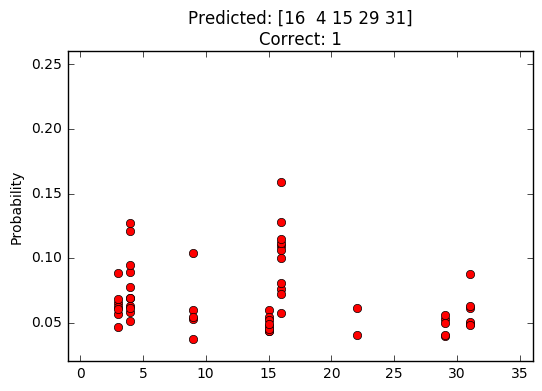

raw top_k results:

tf.nn.top_k(prediction, 5).values  [array([ 0.10939091,  0.08790412,  0.06503177,  0.05420115,  0.05095144], dtype=float32), array([ 0.12754565,  0.11466751,  0.08852632,  0.05994637,  0.04974452], dtype=float32), array([ 0.15914026,  0.08924528,  0.06119757,  0.04326908,  0.0399843 ], dtype=float32), array([ 0.12759867,  0.12108047,  0.10373674,  0.06260558,  0.0555703 ], dtype=float32), array([ 0.07635625,  0.06261338,  0.04757123,  0.04018509,  0.03703041], dtype=float32), array([ 0.07219754,  0.06933605,  0.06821804,  0.05320475,  0.0486108 ], dtype=float32), array([ 0.10027944,  0.0774678 ,  0.05703842,  0.05406843,  0.04508295], dtype=float32), array([ 0.10613582,  0.09468862,  0.06230668,  0.06156643,  0.04922254], dtype=float32), array([ 0.08102242,  0.06919027,  0.06059952,  0.05180895,  0.05091974], dtype=float32), array([ 0.05841279,  0.05735733,  0.04702133,  0.04377867,  0.04033517], dtype=float32), array([ 0.11148612,  0.06101494,  0.05998476,  0.05283

In [35]:
def plot_top_k_probabilities(pred_cls, pred_prob, title):
    plt.plot(list(pred_cls), list(pred_prob), 'ro')
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1-1,x2+1,y1,y2+0.1))

    plt.ylabel('Probability')
    plt.title(title)
 
    plt.show()


for i in range(len(values)):
    predicted_class = indices[i][np.argmax(values[i])]
    # NOTE: You'll need to refer to your newdata's correct labels here. 
    # Swap out "newdata_labels" with your actual "true labels" array.
    correct_class = web_labels[i]
    plot_title = 'Predicted: {}\nCorrect: {}'.format(predicted_class, correct_class) 
    
    plot_top_k_probabilities(indices[i], values[i], plot_title)
    
    print('raw top_k results:')
    print('')
    print('tf.nn.top_k(prediction, 5).values ', list(values[i]))
    print('tf.nn.top_k(prediction, 5).indices', list(indices[i]))
    
    
    print('')
    print('')